In [16]:
import torch
from training.FiretraceMLP import FiretraceMLP

checkpoint = torch.load("../models/firetrace_model.pt")

model = FiretraceMLP(width=checkpoint['model_size'][0], depth=checkpoint['model_size'][1])
compiled_model = torch.compile(model, fullgraph=True, mode="max-autotune")

compiled_model.load_state_dict(checkpoint['model_state_dict'])
compiled_model.eval()

OptimizedModule(
  (_orig_mod): FiretraceMLP(
    (layers): ModuleList(
      (0): Linear(in_features=9, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=40, bias=True)
      (3): ReLU()
      (4): Linear(in_features=40, out_features=40, bias=True)
      (5): ReLU()
      (6): Linear(in_features=40, out_features=40, bias=True)
      (7): ReLU()
      (8): Linear(in_features=40, out_features=40, bias=True)
      (9): ReLU()
      (10): Linear(in_features=40, out_features=40, bias=True)
      (11): ReLU()
      (12): Linear(in_features=40, out_features=40, bias=True)
      (13): ReLU()
      (14): Linear(in_features=40, out_features=40, bias=True)
      (15): ReLU()
      (16): Linear(in_features=40, out_features=40, bias=True)
      (17): ReLU()
      (18): Linear(in_features=40, out_features=40, bias=True)
      (19): ReLU()
      (20): Linear(in_features=40, out_features=40, bias=True)
      (21): ReLU()
      (22): Linear(in_features=40, ou

In [17]:
import pandas as pd

df = pd.read_csv("../data/gen_2/processed/with_fire_area_soi_weather_time.csv")

# Pick last x rows
df = df.tail(500)

y = df["fire_area"]
y = y.reset_index()["fire_area"]
X = df.drop("fire_area", axis=1)

In [18]:
import joblib

x_scaler = joblib.load("../models/x_scaler.save")
y_scaler = joblib.load("../models/y_scaler.save")

x_scaled = x_scaler.transform(X)

In [19]:
print(x_scaled[0].shape)

(9,)


In [28]:
individual_output = compiled_model(torch.tensor(x_scaled[70], dtype=torch.float32).reshape(1, -1))
individual_output_unscaled = y_scaler.inverse_transform(individual_output.detach().numpy().reshape(1, -1))

print("Predicted fire area: ", individual_output_unscaled)

print("Actual fire area: ", y[70])

Predicted fire area:  [[502.3967]]
Actual fire area:  834.72


In [29]:
test_output = compiled_model(torch.tensor(x_scaled, dtype=torch.float32))

test_output

tensor([[0.0319],
        [0.0410],
        [0.0385],
        [0.0385],
        [0.0396],
        [0.0380],
        [0.0410],
        [0.0375],
        [0.0409],
        [0.0429],
        [0.0419],
        [0.0449],
        [0.0484],
        [0.0491],
        [0.0482],
        [0.0439],
        [0.0516],
        [0.0472],
        [0.0500],
        [0.0473],
        [0.0454],
        [0.0527],
        [0.0543],
        [0.0535],
        [0.0610],
        [0.0540],
        [0.0423],
        [0.0565],
        [0.0558],
        [0.0594],
        [0.0595],
        [0.0614],
        [0.0611],
        [0.0622],
        [0.0547],
        [0.0647],
        [0.0660],
        [0.0671],
        [0.0625],
        [0.0586],
        [0.0593],
        [0.0663],
        [0.0651],
        [0.0627],
        [0.0595],
        [0.0699],
        [0.0641],
        [0.0613],
        [0.0547],
        [0.0467],
        [0.0557],
        [0.0611],
        [0.0488],
        [0.0516],
        [0.0487],
        [0

In [30]:
# Unscale the output

y_unscaled = y_scaler.inverse_transform(test_output.detach().numpy())

y_unscaled

array([[ 423.23004],
       [ 544.3423 ],
       [ 510.44736],
       [ 511.39337],
       [ 524.87787],
       [ 504.45245],
       [ 543.506  ],
       [ 498.1618 ],
       [ 543.1777 ],
       [ 569.59106],
       [ 555.64966],
       [ 595.7561 ],
       [ 641.2379 ],
       [ 651.4014 ],
       [ 638.70746],
       [ 582.5097 ],
       [ 684.5695 ],
       [ 626.5827 ],
       [ 663.13654],
       [ 627.8699 ],
       [ 602.25665],
       [ 698.6907 ],
       [ 719.5685 ],
       [ 708.8632 ],
       [ 808.46515],
       [ 716.53925],
       [ 561.5183 ],
       [ 749.4368 ],
       [ 739.28577],
       [ 787.8201 ],
       [ 788.9378 ],
       [ 813.3615 ],
       [ 809.4851 ],
       [ 825.0116 ],
       [ 724.76666],
       [ 858.1465 ],
       [ 875.47595],
       [ 888.9234 ],
       [ 828.2469 ],
       [ 777.22577],
       [ 785.6126 ],
       [ 878.50757],
       [ 862.5086 ],
       [ 831.18024],
       [ 789.0126 ],
       [ 926.9101 ],
       [ 849.96063],
       [ 812.

In [31]:
# Calculate MAE

from sklearn.metrics import mean_absolute_error

mean_absolute_error(y, y_unscaled)

225.1869550708008

Text(0, 0.5, 'Fire Area (sqkm)')

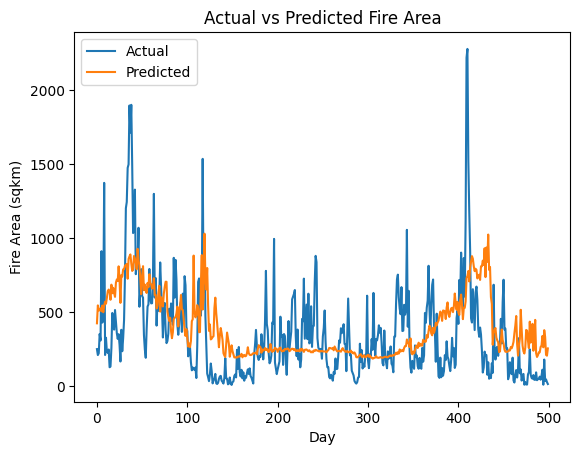

In [32]:
# Graph output vs actual

import matplotlib.pyplot as plt

plt.plot(y, label="Actual")
plt.plot(y_unscaled, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Fire Area")
plt.xlabel("Day")
plt.ylabel("Fire Area (sqkm)")

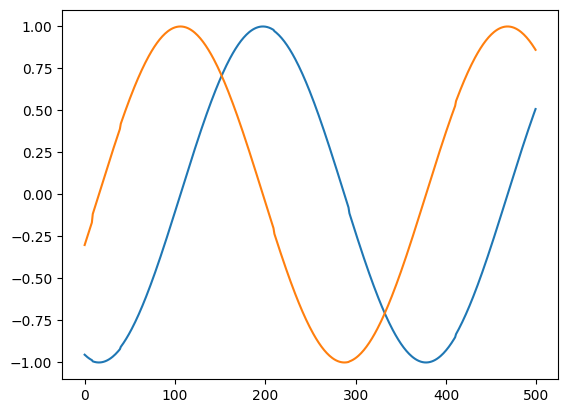

In [34]:
plt.plot(X['sin_signal'].to_numpy())
plt.plot(X['cos_signal'].to_numpy())

